In [1]:
from Data.data_processing import normalize, prepare_balanced_s2p_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
house2 = pd.read_csv("Data/CLEAN_House2.csv", nrows=100000)
print(house2.columns)

Index(['Time', 'Unix', 'Aggregate', 'Appliance1', 'Appliance2', 'Appliance3',
       'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8',
       'Appliance9', 'Issues'],
      dtype='object')


In [3]:
house2_normalized, scalers = normalize(house2, ["Aggregate","Appliance3"])

In [4]:
house2_normalized.head()

,Aggregate,Appliance3
0,0.055110,0.0
1,0.055028,0.0
2,0.055028,0.0
3,0.055689,0.0
4,0.055523,0.0


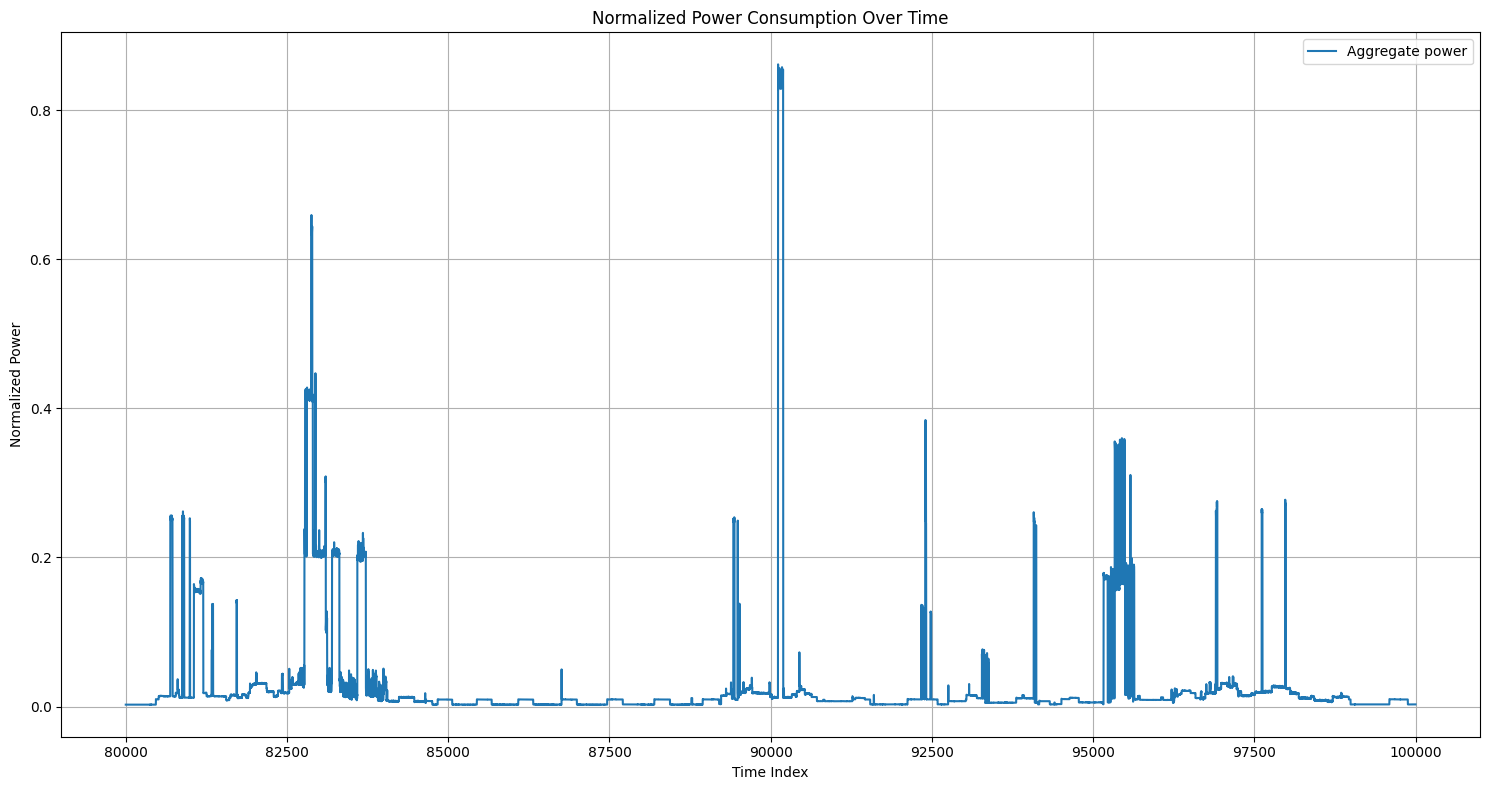

In [5]:
start_index = 80000      # e.g. 0, 5000, 10000
num_points = 100000     # how many points to plot

end_index = start_index + num_points
view_range = house2_normalized.index[start_index:end_index]

# --- Plot ---
plt.figure(figsize=(15, 8))
plt.plot(view_range, house2_normalized["Aggregate"][start_index:end_index], label="Aggregate power")
#plt.plot(view_range, house2_normalized["Appliance3"][start_index:end_index], label="Dishwasher")
plt.xlabel("Time Index")
plt.ylabel("Normalized Power")
plt.title("Normalized Power Consumption Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(house2_normalized["Appliance3"], house2_normalized["Aggregate"], test_size = 0.2,
                                                   shuffle=False)


📊 BEFORE FILTERING
Total points     : 80000
ON points (> 0.1): 3710 (4.64%)
OFF points       : 76290 (95.36%)


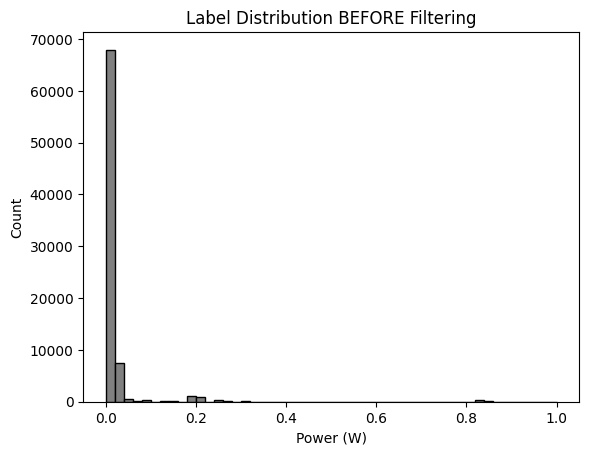

In [12]:
on_threshold = 0.1  # Define the threshold for ON state
num_total = len(y_train)
num_on = np.sum(y_train > on_threshold)
num_off = num_total - num_on

print(f"\n📊 BEFORE FILTERING")
print(f"Total points     : {num_total}")
print(f"ON points (> {on_threshold}): {num_on} ({100 * num_on / num_total:.2f}%)")
print(f"OFF points       : {num_off} ({100 * num_off / num_total:.2f}%)")

plt.hist(y_train, bins=50, color='gray', edgecolor='black')
plt.title("Label Distribution BEFORE Filtering")
plt.xlabel("Power (W)")
plt.ylabel("Count")
plt.show()




✅ AFTER FILTERING (S2P Windows)
Samples created  : 9539
ON points        : 1863 (19.53%)
OFF points       : 7676 (80.47%)


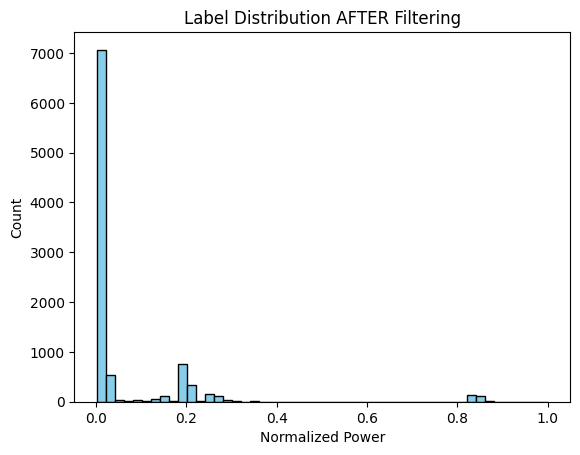

In [13]:
# ---------- PROCESS WITH FUNCTION ----------
sequence_length = 101
stride = 2
off_keep_prob = 0.2

X, y, stats = prepare_balanced_s2p_data(
    X_train,
    y_train,
    sequence_length=sequence_length,
    stride=stride,
    on_threshold=on_threshold,
    off_keep_prob=off_keep_prob,
    normalize=True
)

# ---------- AFTER PROCESSING ----------
num_total_post = len(y)
num_on_post = np.sum(y > (on_threshold / stats["output_max"]) if stats["normalize"] else on_threshold)
num_off_post = num_total_post - num_on_post

print(f"\n✅ AFTER FILTERING (S2P Windows)")
print(f"Samples created  : {num_total_post}")
print(f"ON points        : {num_on_post} ({100 * num_on_post / num_total_post:.2f}%)")
print(f"OFF points       : {num_off_post} ({100 * num_off_post / num_total_post:.2f}%)")

plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.title("Label Distribution AFTER Filtering")
plt.xlabel("Normalized Power" if stats["normalize"] else "Power (W)")
plt.ylabel("Count")
plt.show()